### Dog or Cat Owners Detection From YouTube Comments (Spark, Python, NLP, SQL)

The dataset provided for this project are comments for videos related to animals and/or pets.

 The dataset file is comma separated, with a header line defining the field names, listed here:  
● creator_name. Name of the YouTube channel creator.  
● userid. Integer identifier for the users commenting on the YouTube channels.  
● comment. Text of the comments made by the users.  

Step 1: Identify Cat And Dog Owners  
Find the users who are cat and/or dog owners.

Step 2: Build And Evaluate Classifiers  
Build classifiers for the cat and dog owners and measure the performance of the classifiers.

Step 3: Classify All The Users  
Apply the cat/dog classifiers to all the users in the dataset.   
Estimate the fraction of all users who are cat/dog owners.

Step 4: Extract Insights About Cat And Dog Owners  
Find topics important to cat and dog owners.

Step 5: Identify Creators With Cat And Dog Owners In The Audience  
Find creators with the most cat and/or dog owners.   
Find creators with the highest statistically significant percentages of cat and/or dog owners.

#### Part 1: Data Exploration, Cleaning and Preprocessing

In [4]:
from pyspark.sql import functions as func

In [5]:
df_clean=spark.read.csv("/FileStore/tables/animals_comments.csv",inferSchema=True,header=True)
df_clean.show(10)

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows

In [6]:
df_clean.count() 

Out[5]: 5820035

In [7]:
df_clean = df_clean.na.drop(subset=["comment"])
df_clean.count()

Out[3]: 5818984

In [8]:
df_clean.show()

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟|
Hope For Paws - O...|2911.0| That mother cat l...|
Hope For Paws - O...|2911.0| Its people like H...|
 Talking Kitty Cat|2911.0| steve: No wet foo...|
 Brave Wilderness|3224.0| Dont call this a ...|
 MaxluvsMya|3267.0| why are you alway...|
Rise Up Society F...|3372.0| Deb Tucker|
 The Dodo|3466.0| Thats a deer isnt...|
 Brave Wilderness|3466.0| there is no safe ...|
 Brave Wilderness|3466.0| Red before yellow...|
+--------------------+------+-------------------------------------+
only showing top 20 rows

In [9]:
# find user with preference of dog and cat
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# you can user your ways to extract the label

df_clean = df_clean.withColumn("label", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))

In [10]:
df_clean.show()

+--------------------+------+-------------------------------------+-----+
 creator_name|userid| comment|label|
+--------------------+------+-------------------------------------+-----+
 Doug The Pug| 87.0| I shared this to ...| 0|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| 0|
 bulletproof| 530.0| stop saying get e...| 0|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| 0|
 ojatro|1031.0| I wanna see what ...| 0|
 Tingle Triggers|1212.0| Well shit now Im ...| 0|
Hope For Paws - O...|1806.0| when I saw the en...| 0|
Hope For Paws - O...|2036.0| Holy crap. That i...| 0|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| 0|
 Brian Barczyk|2698.0| Call the teddy Larry| 0|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟| 0|
Hope For Paws - O...|2911.0| That mother cat l...| 0|
Hope For Paws - O...|2911.0| Its people like H...| 0|
 Talking Kitty Cat|2911.0| steve: No wet foo...| 0|
 Brave Wilderness|3224.0| Dont call this a ...| 0|
 MaxluvsMya|3267.0| why are you alway...| 0|
Rise Up Society F...|3372.0| Deb Tucker| 0|
 The Dodo|3466.0| Thats a deer isnt...| 0|
 Brave Wilderness|3466.0| there is no safe ...| 0|
 Brave Wilderness|3466.0| Red before yellow...| 0|
+--------------------+------+-------------------------------------+-----+
only showing top 20 rows

#### Part 2: Build the classifier

In [12]:
df_cut = df_clean.sample(False, 0.4, seed = 50)
df_cut.count()

Out[5]: 2327087

In [13]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W")

word2Vec = Word2Vec(inputCol="words", outputCol="features")

In [14]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, word2Vec])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_cut)
dataset = pipelineFit.transform(df_cut)

In [15]:
dataset.cache()

Out[8]: DataFrame[creator_name: string, userid: double, comment: string, label: int, words: array<string>, features: vector]

In [16]:
dataset.show()

+--------------------+-------+--------------------+-----+--------------------+--------------------+
 creator_name| userid| comment|label| words| features|
+--------------------+-------+--------------------+-----+--------------------+--------------------+
 Doug The Pug| 87.0|I shared this to ...| 0|[i, shared, this,...|[0.06605816653940...|
 Meu Zoológico| 670.0|Tenho uma jiboia ...| 0|[tenho, uma, jibo...|[-0.2376417091970...|
Hope For Paws - O...| 1806.0|when I saw the en...| 0|[when, i, saw, th...|[0.01121401410050...|
Hope For Paws - O...| 2036.0|Holy crap. That i...| 0|[holy, crap, that...|[-0.1429549345316...|
Hope For Paws - O...| 2911.0|That mother cat l...| 0|[that, mother, ca...|[-0.0179323863915...|
 Talking Kitty Cat| 2911.0|steve: No wet foo...| 0|[steve, no, wet, ...|[0.04823312146419...|
 Brave Wilderness| 3466.0|Red before yellow...| 0|[red, before, yel...|[0.02807834271628...|
 Brian Barczyk| 3589.0|Im 7 and I love y...| 0|[im, 7, and, i, l...|[-0.0483522669383...|
 Gohan The Husky| 4533.0|2:35 Why do you l...| 0|[2, 35, why, do, ...|[0.03723872809981...|
 Taylor Nicole Dean| 5697.0|amazing family yo...| 0|[amazing, family,...|[-0.1383445523679...|
 TOMMYfromtheBRONX| 6835.0|Good on ya Tommy ...| 0|[good, on, ya, to...|[0.10313778379932...|
 GoHerping| 7841.0|Can I call you me...| 0|[can, i, call, yo...|[-0.0122928351581...|
 GoHerping| 7841.0|your becoming a m...| 0|[your, becoming, ...|[-0.1318155011940...|
 Kitsune Kreations| 8857.0|I will not put ly...| 0|[i, will, not, pu...|[0.06922546464963...|
 Kitsune Kreations| 8857.0|Part 36 Graystrip...| 0|[part, 36, grayst...|[0.07464672529853...|
 The Dodo| 8935.0| 😱😻| 0| []| (100,[],[])|
 ViralHog| 9312.0| So pure ❤️❤️❤️❤️| 0| [so, pure]|[-0.0383968502283...|
 Taylor Nicole Dean| 9431.0|omg you can see c...| 0|[omg, you, can, s...|[0.04980986405696...|
 Cole & Marmalade| 9431.0|with the green sc...| 0|[with, the, green...|[0.02709131001029...|
 Viktor Larkhill|10269.0|hey victor..you a...| 0|[hey, victor, you...|[-0.0037739259250...|
+--------------------+-------+--------------------+-----+--------------------+--------------------+
only showing top 20 rows

In [17]:
(label0_train,label0_test)=dataset.filter(col('label')==1).randomSplit([0.7, 0.3],seed = 100)
(label1_train, label1_ex)=dataset.filter(col('label')==0).randomSplit([0.005, 0.995],seed = 100)
(label1_test, label1_ex2)=label1_ex.randomSplit([0.002, 0.998],seed = 100)

In [18]:
trainingData = label0_train.union(label1_train)
testData=label0_test.union(label1_test)

In [19]:
print("Dataset Count: " + str(dataset.count()))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Dataset Count: 2328106
Training Dataset Count: 22634
Test Dataset Count: 9292

In [20]:
trainingData.cache()

Out[11]: DataFrame[creator_name: string, userid: double, comment: string, label: int, words: array<string>, features: vector]

In [21]:
testData.cache()

Out[12]: DataFrame[creator_name: string, userid: double, comment: string, label: int, words: array<string>, features: vector]

##### LogisticRegression

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def getEvaluationResult(predictions):
  evaluator = BinaryClassificationEvaluator(
    labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
  AUC = evaluator.evaluate(predictions)
  
  TP = predictions.filter((func.col('label') == 1) & (func.col('prediction') == 1.0)).count()
  FP = predictions.filter((func.col('label')== 0) & (func.col('prediction') == 1.0)).count()
  TN = predictions.filter((func.col('label') == 0) & (func.col('prediction') == 0.0)).count()
  FN = predictions.filter((func.col('label') == 1) & (func.col('prediction') == 0.0)).count()
  
  accuracy = (TP + TN) * 1.0 / (TP + FP + TN + FN)
  precision = TP * 1.0 / (TP + FP)
  recall = TP * 1.0 / (TP + FN)
  
  print ('True Positives: ', TP)
  print ('False Positives: ', FP)
  print ('True Negatives: ', TN)
  print ('False Negatives: ', FN)
  print ('Test Accuracy: ', accuracy)
  print ('Test Precision: ', precision)
  print ('Test Recall: ', recall)
  print ('Test AUC of ROC: ', AUC)

In [24]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrmodel = lr.fit(trainingData)

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions_lr = lrmodel.transform(testData)

In [25]:
print ('Prediction result summary: ')
getEvaluationResult(predictions_lr)

Prediction result summary: 
True Positives: 4371
False Positives: 527
True Negatives: 3958
False Negatives: 436
Test Accuracy: 0.8963624623331898
Test Precision: 0.8924050632911392
Test Recall: 0.9092989390472228
Test AUC of ROC: 0.9516492461871042

In [26]:
predictionslr_train = lrmodel.transform(trainingData)
print ('Prediction result summary: ')
getEvaluationResult(predictionslr_train)

Prediction result summary: 
True Positives: 10344
False Positives: 1293
True Negatives: 10041
False Negatives: 956
Test Accuracy: 0.900636211009985
Test Precision: 0.8888888888888888
Test Recall: 0.9153982300884955
Test AUC of ROC: 0.9566239570499008

In [27]:
# View model's predictions and probabilities of each prediction class
selected = predictions_lr.select("label", "prediction", "probability", "creator_name", "userid", "comment")
display(selected)

label,prediction,probability,creator_name,userid,comment
1,1.0,"List(1, 2, List(), List(1.6863072710207935E-4, 0.999831369272898))",Aarons Animals,881725.0,my cat died like if you agree
1,1.0,"List(1, 2, List(), List(0.10770324283685252, 0.8922967571631476))",AfroHerpkeeper,932246.0,So a broad-headed skink got into my house and its hiding somewhere in my room I cant find it; any tips on how to lure it out of wherever its hiding? I dont want my dogs or cats to get it!
1,1.0,"List(1, 2, List(), List(0.07222481163678646, 0.9277751883632136))",Alex Knappenberger,8896.0,yeah my dog does that in the kitchen then rolls in it 😆
1,0.0,"List(1, 2, List(), List(0.7591220985887516, 0.24087790141124849))",Alex Knappenberger,194047.0,Hahaha... thats so funny. Ive been thinking about how I can see my dogs when Im not home. this is a great idea. Thanks for the mod info too.
1,1.0,"List(1, 2, List(), List(0.14635682409740597, 0.8536431759025941))",BarkBox,803283.0,BAHAHA The frito paws <3 I swear my pups feet are the best smelling chips! My husband laughs at me and I say But just smell them!
1,1.0,"List(1, 2, List(), List(0.07111169328454935, 0.9288883067154506))",Big Cat Rescue,500667.0,Exactly how I talk to my cats: Hi baby!!! I also throw in Bushki Bubbeleh Boobie and Bubke.
1,1.0,"List(1, 2, List(), List(3.5750076750287177E-4, 0.999642499232497))",Big Cat Rescue,1151409.0,I wish my cat was as playful as that 😹🙀
1,1.0,"List(1, 2, List(), List(0.09869879751363902, 0.9013012024863609))",Big Cat Rescue,1620383.0,ah ive tried this so many time with my cats but they never seem to be interested lol
1,1.0,"List(1, 2, List(), List(0.11875877670537063, 0.8812412232946293))",Big Cat Rescue,1931382.0,my cat once jumped about 7 feet into the air to catch a bird
1,1.0,"List(1, 2, List(), List(0.4855465532827932, 0.5144534467172067))",Big Cat Rescue,2378111.0,Okay but honestly this is so cute. I know that pumas should either be left in the wild or cared for by professionals but these cats warmed my heart and I want one now. The only difference between these guys and my cars are that these guys could probably actually eat me rather than the pathetic attempts my cats make.


##### Parameter Tuning and K-fold cross-validation

In [29]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set to measure the accuracy of our model on new data
predictions_cv = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print ('Prediction result summary: ')
getEvaluationResult(predictions_cv)

/databricks/spark/python/pyspark/ml/util.py:785: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Prediction result summary: 
True Positives: 4408
False Positives: 552
True Negatives: 3933
False Negatives: 399
Test Accuracy: 0.8976538958243651
Test Precision: 0.8887096774193548
Test Recall: 0.9169960474308301
Test AUC of ROC: 0.9520595545468702

In [30]:
print ('Best Param (regParam): ' , cvModel.bestModel._java_obj.getRegParam())
print ('Best Param (maxIter): ' , cvModel.bestModel._java_obj.getMaxIter())
print ('Best Param (elasticNetParam): ' , cvModel.bestModel._java_obj.getElasticNetParam())

Best Param (regParam): 0.01
Best Param (maxIter): 10
Best Param (elasticNetParam): 0.0

In [31]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]  # convert numpy type to float, and to tuple
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
display(weightsDF)

Feature Weight
4.7759414002414635
-2.5796482101778464
3.6867311952136816
0.08576049531836596
3.8449055027333796
3.148382057333973
3.3981971115207275
-1.109424084172347
0.7357545395026462
-2.3005696082922555


In [32]:
# View best model's predictions and probabilities of each prediction class
selected = predictions_cv.select("label", "prediction", "probability", "creator_name", "userid", "comment")
display(selected)

label,prediction,probability,creator_name,userid,comment
1,0.0,"List(1, 2, List(), List(0.5929042231446437, 0.4070957768553562))",Aarons Animals,937383.0,This is like my cat zack so clumsy.btw i love youre animations!
1,1.0,"List(1, 2, List(), List(0.09876877483828264, 0.9012312251617174))",Alex Knappenberger,8896.0,yeah my dog does that in the kitchen then rolls in it 😆
1,1.0,"List(1, 2, List(), List(0.3499122503501274, 0.6500877496498725))",Alex Knappenberger,194047.0,Lucy is so cute. she was looking at Bruce and Dexter to see if they were going to go. my dogs are like that too. lazy bums. hahaha
1,1.0,"List(1, 2, List(), List(0.23260566626680876, 0.7673943337331912))",Alex Knappenberger,446192.0,Is it normal for my dog to stick her snout on the back edge of the water bowl and lick the water up using the side of the bowl?
1,1.0,"List(1, 2, List(), List(0.054625988597940905, 0.9453740114020591))",Aquarium Co-Op,771209.0,lol I heard a cat in the background as I was feeding my cat.
1,0.0,"List(1, 2, List(), List(0.5746935518156476, 0.42530644818435237))",Big Bear Homestead,691254.0,Glad yall are safe. I spent 1/2 hour or more locked down in the bathroom at the bank with about 20 strangers. Please forgive me for posting this as it was also in the live chat. They locked the doors and told us that no one could leave or enter. There was a suspect tornado on the ground just down the street. Then on the way home I hydroplaned twice. Then I took my dog (one that seemed healthy) to the vet. The bump on her had that they told me a week ago was probably an abscess is now suspected to be a fast growing cancer. Waiting on the next round maybe Ill get lucky and they will take this whole place out. Did I mention that we bought a very used truck in the process? Yes. That sucks too. Used trucks are outrageous expensive.
1,1.0,"List(1, 2, List(), List(0.0014125199436126803, 0.9985874800563873))",Big Cat Rescue,70179.0,One of them looked exactly like my cat
1,1.0,"List(1, 2, List(), List(0.004526608105057022, 0.9954733918949429))",Big Cat Rescue,1151409.0,I wish my cat was as playful as that 😹🙀
1,1.0,"List(1, 2, List(), List(0.025350829826750226, 0.9746491701732497))",Big Cat Rescue,1952472.0,Omg I see my pet cat Milo in there eyes😂..... It might be the meow my cat has a weird meow but its cute
1,1.0,"List(1, 2, List(), List(0.3737111241207285, 0.6262888758792715))",Big Cat Rescue,2103241.0,That purring gave me chillz. Its like how my cat purrs when hes hungry and i suspect hes thinking this big juicy steak looking bastard just a few inches closer. =^-^=


##### RandomForest

In [34]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(trainingData)
predictions_rf = rfModel.transform(testData)
predictions_rf.select('creator_name', 'userid', 'comment', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+------------------+---------+--------------------+-----+--------------------+----------+--------------------+
 creator_name| userid| comment|label| rawPrediction|prediction| probability|
+------------------+---------+--------------------+-----+--------------------+----------+--------------------+
 Aarons Animals| 937383.0|This is like my c...| 1|[9.50547664517011...| 1.0|[0.47527383225850...|
Alex Knappenberger| 8896.0|yeah my dog does ...| 1|[4.49875750988456...| 1.0|[0.22493787549422...|
Alex Knappenberger| 194047.0|Lucy is so cute. ...| 1|[6.83214669578087...| 1.0|[0.34160733478904...|
Alex Knappenberger| 446192.0|Is it normal for ...| 1|[6.72430030174722...| 1.0|[0.33621501508736...|
 Aquarium Co-Op| 771209.0|lol I heard a cat...| 1|[5.10293767560002...| 1.0|[0.25514688378000...|
Big Bear Homestead| 691254.0|Glad yall are saf...| 1|[7.04152583174115...| 1.0|[0.35207629158705...|
 Big Cat Rescue| 70179.0|One of them looke...| 1|[3.59842923217057...| 1.0|[0.17992146160852...|
 Big Cat Rescue|1151409.0|I wish my cat was...| 1|[8.96158368280940...| 1.0|[0.44807918414047...|
 Big Cat Rescue|1952472.0|Omg I see my pet ...| 1|[3.78611405119180...| 1.0|[0.18930570255959...|
 Big Cat Rescue|2103241.0|That purring gave...| 1|[7.56567017762581...| 1.0|[0.37828350888129...|
+------------------+---------+--------------------+-----+--------------------+----------+--------------------+
only showing top 10 rows

In [35]:
print ('Prediction result summary: ')
getEvaluationResult(predictions_rf)

Prediction result summary: 
True Positives: 4367
False Positives: 674
True Negatives: 3811
False Negatives: 440
Test Accuracy: 0.8801119242359019
Test Precision: 0.8662963697679031
Test Recall: 0.9084668192219679
Test AUC of ROC: 0.9448716209337048

##### Gradient boosting

In [37]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(trainingData)
predictions_gdbt = gbtModel.transform(testData)
predictions_gdbt.select('creator_name', 'userid', 'comment', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+------------------+---------+--------------------+-----+--------------------+----------+--------------------+
 creator_name| userid| comment|label| rawPrediction|prediction| probability|
+------------------+---------+--------------------+-----+--------------------+----------+--------------------+
 Aarons Animals| 937383.0|This is like my c...| 1|[0.16957586535268...| 0.0|[0.58398445347761...|
Alex Knappenberger| 8896.0|yeah my dog does ...| 1|[-1.1037266990992...| 1.0|[0.09908316537119...|
Alex Knappenberger| 194047.0|Lucy is so cute. ...| 1|[-0.6235475892666...| 1.0|[0.22320338233863...|
Alex Knappenberger| 446192.0|Is it normal for ...| 1|[-0.8004007259464...| 1.0|[0.16786963071508...|
 Aquarium Co-Op| 771209.0|lol I heard a cat...| 1|[-0.9541006197272...| 1.0|[0.12918306842493...|
Big Bear Homestead| 691254.0|Glad yall are saf...| 1|[-0.3053657437505...| 1.0|[0.35189235379409...|
 Big Cat Rescue| 70179.0|One of them looke...| 1|[-1.1739625801643...| 1.0|[0.08723083310338...|
 Big Cat Rescue|1151409.0|I wish my cat was...| 1|[-0.2691673701400...| 1.0|[0.36857504907658...|
 Big Cat Rescue|1952472.0|Omg I see my pet ...| 1|[-1.1665850471093...| 1.0|[0.08841283274343...|
 Big Cat Rescue|2103241.0|That purring gave...| 1|[-0.3374715204968...| 1.0|[0.33739089636943...|
+------------------+---------+--------------------+-----+--------------------+----------+--------------------+
only showing top 10 rows

In [38]:
print ('Prediction result summary: ')
getEvaluationResult(predictions_gdbt)

Prediction result summary: 
True Positives: 4362
False Positives: 719
True Negatives: 3766
False Negatives: 445
Test Accuracy: 0.8747309513560052
Test Precision: 0.8584924227514269
Test Recall: 0.9074266694403994
Test AUC of ROC: 0.9418176623230867

In [39]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(trainingData)
predictions_cv_gdbt = cvModel.transform(testData)
print ('Prediction result summary: ')
getEvaluationResult(predictions_cv_gdbt)

/databricks/spark/python/pyspark/ml/util.py:785: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Test Area Under ROC: 0.9594173746195717

In [40]:
print ('Best Param (maxDepth): ' , cvModel.bestModel._java_obj.getMaxDepth())
print ('Best Param (maxIter): ' , cvModel.bestModel._java_obj.getMaxIter())
print ('Best Param (maxBins): ' , cvModel.bestModel._java_obj.getMaxBins())

Best Param (maxDepth): 6
Best Param (maxIter): 20
Best Param (maxBins): 60

In [41]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt_best = GBTClassifier(maxIter=20, maxBins=60, maxDepth=6)
gbtBestModel = gbt_best.fit(trainingData)
predictions_best = gbtBestModel.transform(testData)
print ('Prediction result summary: ')
getEvaluationResult(predictions_best)

Prediction result summary: 
True Positives: 4317
False Positives: 571
True Negatives: 3906
False Negatives: 430
Test Accuracy: 0.8914787510841283
Test Precision: 0.8831833060556464
Test Recall: 0.9094164735622499
Test AUC of ROC: 0.9589790648258181

#### Part 3: Classify All The Users

In [43]:
dataset_unknown = dataset.filter(func.col('label') == 0)
print ('There are {} users whose attribute is unclear.'.format(dataset_unknown.count()))

There are 2311198 users whose attribute is unclear.

In [44]:
predictions_unknown = gbtBestModel.transform(dataset_unknown)
predictions_unknown.select('creator_name', 'userid', 'comment', 'label', 'prediction', 'rawPrediction', 'probability').show(10)

+--------------------+------+-------------------------------------+-----+----------+--------------------+--------------------+
 creator_name|userid| comment|label|prediction| rawPrediction| probability|
+--------------------+------+-------------------------------------+-----+----------+--------------------+--------------------+
 Tingle Triggers|1212.0| Well shit now Im ...| 0| 0.0|[0.75901522904284...|[0.82024827241701...|
Hope For Paws - O...|2036.0| Holy crap. That i...| 0| 0.0|[1.54912878577382...|[0.95682081434763...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| 0| 0.0|[1.54684560092662...|[0.95663176191735...|
Hope For Paws - O...|2911.0| That mother cat l...| 0| 1.0|[-1.3253621115182...|[0.06594438642326...|
 MaxluvsMya|3267.0| why are you alway...| 0| 0.0|[1.21610393787566...|[0.91925057287665...|
 Gohan The Husky|4533.0| 2:35 Why do you l...| 0| 0.0|[0.90460720164598...|[0.85926690099194...|
 Brave Wilderness|8786.0| WOW I got dooped| 0| 0.0|[0.14317678750069...|[0.57110319428613...|
 Kitsune Kreations|8857.0| Part 36 Graystrip...| 0| 1.0|[-0.3460353273432...|[0.33357260421229...|
 The Dodo|8935.0| 😱😻| 0| 0.0|[1.54684560092662...|[0.95663176191735...|
 ViralHog|9312.0| So pure ❤️❤️❤️❤️| 0| 0.0|[1.16742954538714...|[0.91172319903183...|
+--------------------+------+-------------------------------------+-----+----------+--------------------+--------------------+
only showing top 10 rows

In [45]:
# Number of total users in out used dataset
total_user = dataset.select('userid').distinct().count()
# Number of labeled owners
owner_labeled = dataset.filter(func.col('label') == 1).select('userid').distinct().count()
# Number of predicted owners
owner_predicted = predictions_unknown.filter(func.col('prediction') == 1.0).select('userid').distinct().count()
# Fraction of the owners
fraction = (owner_labeled + owner_predicted) / total_user
print ('Fraction of the users who have cat/dog: ', round(fraction, 3))

Fraction of the users who have cat/dog: 0.179

#### Part 4: Get insigts of Users

In [47]:
from pyspark.ml.feature import StopWordsRemover

owners = dataset.filter(func.col('label') == 1).select('words')\
                .union(predictions_unknown.filter(func.col('prediction') == 1.0).select('words'))
remover_raw = StopWordsRemover(inputCol='raw', outputCol='filtered')
stopwords = remover_raw.getStopWords()
stopwords_custom = ['im', 'get', 'got', 'one', 'hes', 'shes', 'dog', 'dogs', 'cat', 'cats', 'kitty', 'much', \
                    'really', 'love', 'like', 'dont', 'know', 'want', 'thin', 'see', 'also', 'never', 'go', 'ive']
stopwords = stopwords + stopwords_custom
remover = StopWordsRemover(inputCol='words', outputCol='filtered', stopWords=stopwords)
owners = remover.transform(owners)
owners.show(10)

+--------------------+--------------------+
 words| filtered|
+--------------------+--------------------+
[now, i, want, to...| [try]|
[thats, what, my,...| [thats]|
[im, so, happy, i...|[happy, think, al...|
[random, kitty, l...|[random, looks, d...|
[what, worries, m...|[worries, anythin...|
[i, also, faced, ...|[faced, dogat, lo...|
[i, want, all, th...|[plz, jump, dose,...|
[just, saw, this,...|[saw, video, pret...|
[massive, comment...|[massive, comment...|
[i, relate, to, t...|[relate, hedgehog...|
+--------------------+--------------------+
only showing top 10 rows

In [48]:
owner = owners.withColumn('filtered', func.explode('filtered'))
owner = owner.groupBy('filtered').agg(func.countDistinct('words').alias('count'))

In [49]:
owner.show(1)

+--------+-----+
filtered|count|
+--------+-----+
 still|10542|
+--------+-----+
only showing top 1 row

In [50]:
spread = owner.withColumn('spread', func.struct(owner['filtered'], owner['count']))

In [51]:
spread.show(1)

+--------+-----+--------------+
filtered|count| spread|
+--------+-----+--------------+
 still|10542|[still, 10542]|
+--------+-----+--------------+
only showing top 1 row

In [52]:
spread_list = spread.select('spread').collect()

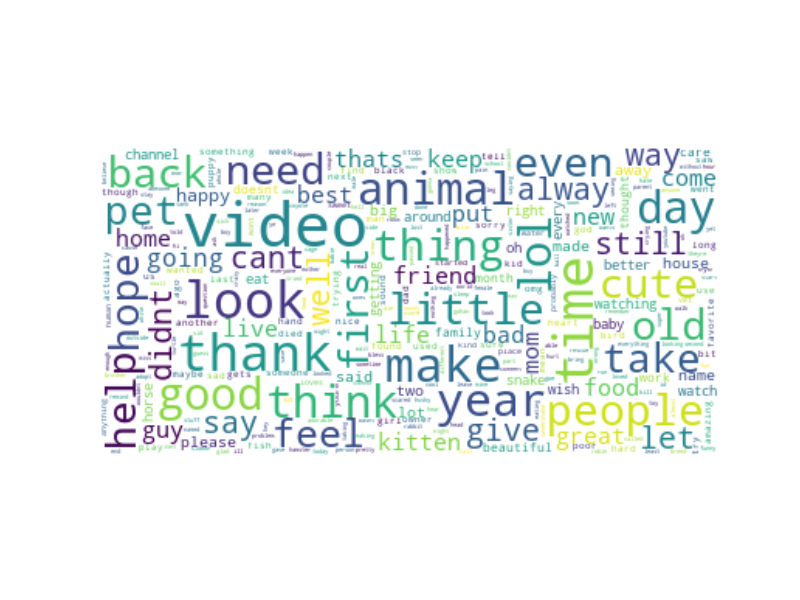

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ''.join([(item[0][0] + ' ') * item[0][1] for item in spread_list])
wordcloud = WordCloud(background_color='white', max_words=20000, collocations=False, \
                      contour_width=3, contour_color='red', max_font_size=40)
wordcloud.generate(text)
fig, ax = plt.subplots(nrows=1, figsize=(8, 6))
ax.imshow(wordcloud, interpolation='bilinear')

ax.axis('off')
display(fig)

#### Part 5: Identify Creators With Cat And Dog Owners In The Audience

In [55]:
creator = dataset.filter(func.col('label') == 1).select('creator_name')\
                 .union(predictions_unknown.filter(func.col('prediction') == 1.0).select('creator_name'))
creator_count = creator.groupBy('creator_name').count().orderBy('count', ascending=False)
creator_count.show(5)

+------------------+-----+
 creator_name|count|
+------------------+-----+
 Brave Wilderness|35606|
 The Dodo|21892|
Taylor Nicole Dean|17076|
 Brian Barczyk|15707|
 Robin Seplut|13582|
+------------------+-----+
only showing top 5 rows